# Hough（ハフ） 変換

<img width="250" alt="▼□" src="https://user-images.githubusercontent.com/5820803/81265801-a662e700-907e-11ea-80ba-4f1bf6a611c8.png">

　例えば、上の図を人が見れば、子供の描く家の形、とか、四角形の上に三角形が乗っているとか、線分６本で描かれている、と認識する。少しぐらいの途切れ、はみ出し、ずれなどはとは無視して、そういう認識ができる。

　人にとってはごく当たり前のことであるが、画像のRAWデータは単に画素の色や明るさの数値データが並んでいるだけであり、三角形があるか？　とか、どんな直線がどこにあるか、といった記述レベルの検索要求に、即座に答えることはできない。

　画像にもとづいた判断や応用が、画素ひとつひとつの色や濃度などといった原始的な記述レベルで済むことはまれであり、最低限、直線成分や円弧成分に基いた記述レベルが必要不可欠となる。

　その要求にこたえうる手法が**ハフ変換**である。ハフ変換は画像中に存在する直線や円の成分を検出するための手法である。（講義で説明したので理論説明は略）

- [参考URL](https://jp.mathworks.com/discovery/image-transform.html)

#【課題】
　上で述べたことを踏まえ、この実験では実際の画像に対し、直線検出のためのハフ変換をこころみて、実際にハフ変換でどのような直線が検出されるのか（あるいは、思わぬ直線が検出されてしまうのか）ということを実践的に理解し、どのような応用が考えうるかを考察することを課題とする。

## 実験概要

- 直線検出の応用を念頭に、処理対象画像を用意する。
- グレー画像変換　→　Canny法による２値エッジ画像生成　→　ハフ変換という流れで、用意した画像の直線成分を検出する。
- 結果に基づき、
>- どのような応用が考えられるか
>- どのようにハフ変換を応用するのか
>- その際にどういう問題を解決しないといけないのか

を考察する。



---

以下に用意された python プログラムを、説明を読みながら、順に実行していきなさい。



In [1]:
import urllib.request
from google.colab import files
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import widgets

# 1.  画像のアップロードと読み込み
## 対象画像について
ハフ変換が直線を検出する処理であることをふまえ，直線を検出することで何ができるようになるか，ということを意識して画像を選ぶこと．

次のセルで、３つの指定方法のうちのどれかを使って、処理対象画像を指定してください。

1. **URL指定**
　ネット上の画像を処理対象とする。画像のurlを **url** に指定し、仮のファイル名を付けてください。
2. **アップロード**
　実行時にファイルをアップロードする。ファイル名はアップロードしたファイルの名前が使われますので、指定は無視されます。
3. **事前アップロード** Google Colaborory に事前にアップロードしてあるファイルを処理対象とします。アップロードしてあるファイル名を指定してください。

（注）事前アップロードを使う場合には、あらかじめ、左のエリアのアップロード機能を使って画像ファイルをアップロードしておく必要があります。

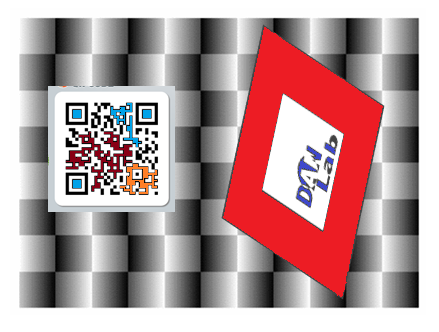

         Fig.１　処理対象画像 hsample.png


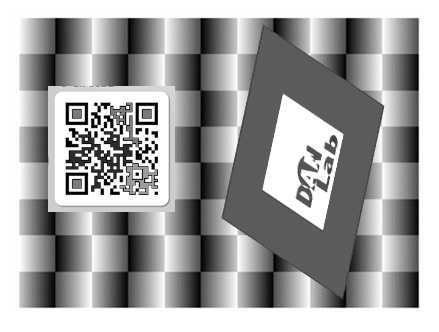

         Fig.２　hsample.pngのグレースケール化


In [2]:
# 処理対象画像の指定　default URL指定　https://bit.ly/2WaJ26n
# テスト用　道路画像　http://www.teikoku-eng.co.jp/gyoumu/06_douro/sintokoro.jpg
画像入力方法 = "URL\u6307\u5B9A"  #@param ["アップロード","事前アップロード", "URL指定"]
url="https://bit.ly/2WaJ26n" #@param {type:"string"}
ファイル名を入力してください="hsample.png" #@param {type:"string"}
if 画像入力方法 == "事前アップロード":
  filename = ファイル名を入力してください
  img = cv2.imread(filename,1) # カラーで読み込み
elif 画像入力方法 == "アップロード":
  filename = list(files.upload())[0]
  img = cv2.imread(filename,1) # カラーで読み込み
else: # URLからのダウンロード
  img_path, header = urllib.request.urlretrieve(url)
  img = cv2.imread(img_path,1)  
  filename = ファイル名を入力してください
  cv2.imwrite(filename,img)

if img.shape[1] > 600: # 幅が600以上の場合は600になるようリサイズ
  r = 600/img.shape[1]
  img = cv2.resize(img,(600,int(r*img.shape[0])))

gry = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

cv2_imshow(img)
print("         Fig.１　処理対象画像 {}".format(filename))


cv2_imshow(gry)
print("         Fig.２　{}のグレースケール化".format(filename))

# 2. Canny法によるエッジ検出
　ハフ変換は２階調の線画に直線をあてはめる処理である．境界以外に直線が当てはまることはなく処理時間の無駄となるので，まずエッジ検出を行う．
エッジ検出のフィルタは数多く存在するが，ここでは結果が２値となる，Canny法を用いる．

![Alt text](https://monosnap.com/image/F07UTJ0ByXNJG5OJVaxOnzeBp0YxNH)

　Canny 法は複数のステップで２階調の線画像を得る．

1. ガウシアンフィルタにより画像を平滑化する．ノイズの除去がその目的である．
2. Sobel のフィルタによりエッジ強度の勾配と方向を求め
3. エッジ上の点では勾配方向に対して勾配の強さが極大となっているはずであるから，それ以外の点は除外する．
4. エッジの候補点のうち，パラメータmaxValよりも強度の強い点をエッジであると確定する．
5. すでにエッジであると確定している点に連続する点で，パラメータ minVal よりもエッジ強度の強い点もエッジに加える．この操作を再帰的に実行する．

　たとえば，図１を原画像とするとエッジ強度は図２のようになる．図３は赤枠と青枠の部分を水平方向に見たとき，水平方向を横軸，エッジ強度を縦軸に取ったグラフである．たとえば，図３の緑のレベルをしきい値として図２を２階調化すると図４のような２値画像が得られる．赤枠部のエッジは中央部が途切れ，青枠部は中央部のみが検出される．

 　図に示すmaxValとminValをパラメータとして指定したとすると，青部分はエッジ強度が弱く maxVal を超える点がないため，Canny法ではエッジではないと判断される．赤部分は左右の部分が maxVal を超えるため，ステップ４でエッジ点と確定する．中央部はそれらの点と連続しており，minVal よりも強度が強いため，ステップ５でエッジ点に追加される．
  結果として，Canny法のエッジ検出結果は図５に示すように，赤枠部が横１線のラインとなり，青枠部分の弱いエッジは無視される．

## Canny 法のパラメータ設定

cv2.Canny(画像, minVal, maxVal)

<img width="470" alt="コメント 2020-05-07 153049" src="https://user-images.githubusercontent.com/5820803/81261860-cba02700-9077-11ea-84b8-068a4286295a.png">


【課題：Canny法のパラメータ調整】

２つのしきい値、minVal, maxValの組み合わせにより、得られるエッジ画像が変化する。

最適と思われる組み合わせを探す。

###（注）
- ここでの処理の目的は、検出したい直線上の点のみが、なるべくきれい現れている画像を作ることである。
- この実験の主題は、次のステップのハフ変換であり、エッジ検出は、ハフ変換の対象となる線画像の生成である。途切れやノイズはないに越したことはないが、途切れやノイズがあっても、なるべく多くの黒画素を通過する直線を見つける、というのがハフ変換の性質であるので、少々の途切れや、ノイズが残っても気にしなくてよい。

## 調整方法の例

1.コアとなる強いエッジがすべて検出されるよう MaxVal を調整する。MinValの値はMaxValと同じにしておく。  
2.MinValを０～MaxValの範囲で調節し、残したいエッジがなるべく多くなり、ノイズがなるべく少なくなるように調整する。 


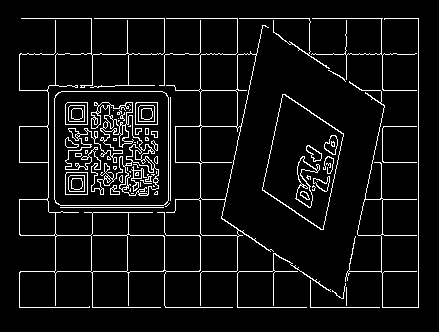

  Fig.3 エッジ検出結果


In [3]:
maxVal = 203 #@param {type:"slider", min:0, max:1500, step:1}
minVal = 77 #@param {type:"slider", min:0, max:1500, step:1}

canny = cv2.Canny(gry, minVal, maxVal)

cv2_imshow(canny)
print("  Fig.3 エッジ検出結果".format(filename))

# 3. Hough 変換

次のセルでハフ変換を実行する。投票（その直線上に乗る点の数）がthresを超えた直線のみを採用して表示する。

仮に thres は 100 としてあるが、目的に応じて、望ましい直線が検出されるように調整すること。

lines = cv2.HoughLines(canny,1,np.pi/180,thres)

投票 100点以上の直線は 32本検出されました.



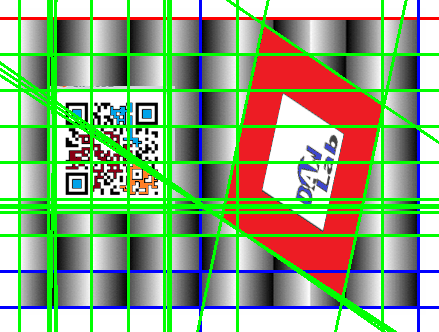

         Fig.4　直線検出結果


In [4]:
# thres default 100
thres = 100#@param {type:"slider", min:0, max:255, step:1}
lines = cv2.HoughLines(canny,1,np.pi/180,thres)
img2 = img.copy()
print("投票 {}点以上の直線は {}本検出されました.\n".format(thres,len(lines)))
for index, [[rho,theta]] in enumerate(lines):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    if index == 0:
      color = (0,0,255)
    elif index < 5 :
      color = (255,0,0)
    else:
      color = (0,255,0)
    cv2.line(img2,(x1,y1),(x2,y2),color,2)
    
cv2_imshow(img2)
print("         Fig.4　直線検出結果")

### 線の色の意味
<font color=red>*赤*</font>　投票が１位の直線（最も多くの黒画素が乗っている直線）  
<font color=blue>*青*</font>　投票が２位～５位の直線  
<font color=green>*緑*</font>　投票が６位～の直線